In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import spacy as sc
import xgboost as xgb

%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve

In [3]:
df = pd.read_json("headlines.json", lines=True)

In [4]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
df.shape

(26709, 2)

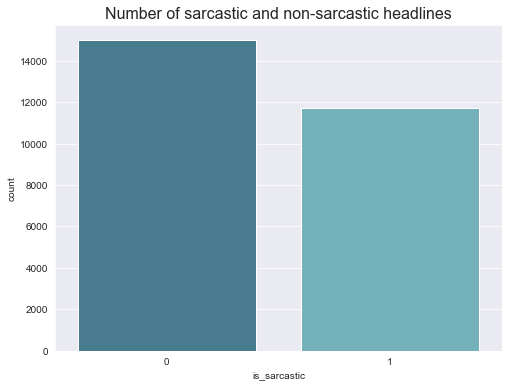

In [6]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(x="is_sarcastic", data=df, palette="GnBu_d").set_title(
    "Number of sarcastic and non-sarcastic headlines", fontsize=16
)
plt.savefig("plot1.png")

In [7]:
stopwords = set(STOPWORDS)

In [21]:
sarcastic = ""
for headline in df.headline[df.is_sarcastic == 1]:
    for word in headline.lower().split():
        sarcastic += word + " "

In [22]:
non_sarcastic = ""
for headline in df.headline[df.is_sarcastic == 0]:
    for word in headline.lower().split():
        non_sarcastic += word + " "

In [23]:
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    min_font_size=14,
).generate(sarcastic)
wordcloud2 = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    min_font_size=14,
).generate(non_sarcastic)

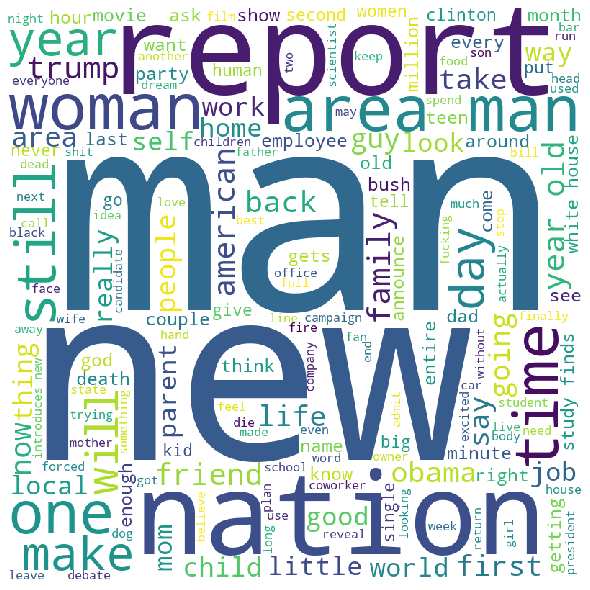

In [24]:
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("plot2.png")
plt.show()

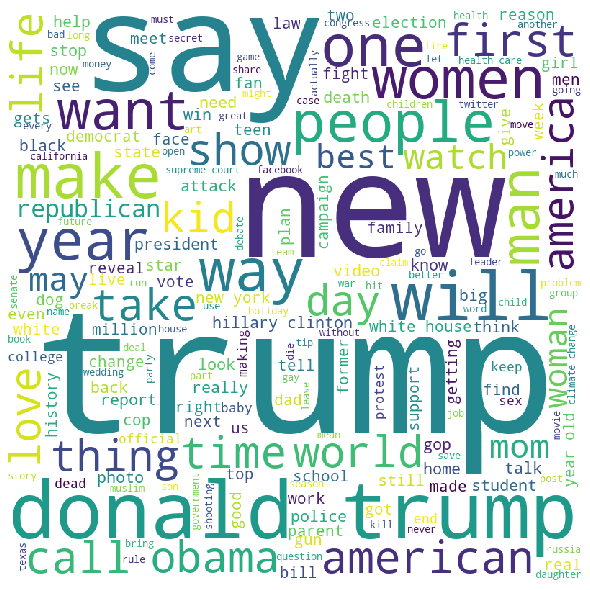

In [25]:
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("plot3.png")
plt.show()

In [ ]:
# !python -m spacy download en_core_web_md

In [26]:
nlp = sc.load("en_core_web_md")

In [27]:
proccessed_tokens = []
for doc in df["headline"]:
    doc = nlp(doc)
    proccessed_token = ""
    for token in doc:
        if token.is_stop or token.is_punct or token.is_digit:
            pass
        else:
            proccessed_token += token.lemma_.lower() + " "
    proccessed_tokens.append(proccessed_token)

In [28]:
df["processed_headline"] = np.array(proccessed_tokens)

In [29]:
df["headline"][6]

'the fascinating case for eating lab-grown meat'

In [30]:
df["processed_headline"][6]

'fascinating case eat lab grow meat '

In [31]:
cvec = CountVectorizer(analyzer="word", ngram_range=(1, 4))
X_cvec = cvec.fit_transform(df["headline"])
X2_cvec = cvec.fit_transform(df["processed_headline"])

In [32]:
tf = TfidfVectorizer(analyzer="word", ngram_range=(1, 4))
X_tf = tf.fit_transform(df["headline"])
X2_tf = tf.fit_transform(df["processed_headline"])

In [33]:
y = df["is_sarcastic"]

In [34]:
# for count vectorizer:
X_train_cvec, X_valid_cvec, y_train_cvec, y_valid_cvec = train_test_split(
    X_cvec, y, test_size=0.2, random_state=42
)
X2_train_cvec, X2_valid_cvec, y2_train_cvec, y2_valid_cvec = train_test_split(
    X2_cvec, y, test_size=0.2, random_state=42
)

In [35]:
# for tfid:
X_train_tf, X_valid_tf, y_train_tf, y_valid_tf = train_test_split(
    X_tf, y, test_size=0.2, random_state=42
)
X2_train_tf, X2_valid_tf, y2_train_tf, y2_valid_tf = train_test_split(
    X2_tf, y, test_size=0.2, random_state=42
)

In [36]:
def get_results(model, X_train, y_train, X_valid, y_valid, return_pred=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    if return_pred:
        return pred
    else:
        print("Accuracy: ", np.round(accuracy_score(y_valid, pred), 2))
        print(confusion_matrix(y_valid, pred))

In [37]:
# let's start with something very simple: logistic regression
lr_classifier = LogisticRegression(C=1, max_iter=200, solver="lbfgs", random_state=42)

In [38]:
# using CountVectorizer
get_results(lr_classifier, X2_train_cvec, y2_train_cvec, X2_valid_cvec, y2_valid_cvec)

Accuracy:  0.79
[[2620  376]
 [ 765 1581]]


In [39]:
# using CountVectorizer + some NLP transformations
get_results(lr_classifier, X_train_cvec, y_train_cvec, X_valid_cvec, y_valid_cvec)

Accuracy:  0.85
[[2605  391]
 [ 421 1925]]


In [40]:
# using tfid:
get_results(lr_classifier, X2_train_tf, y2_train_tf, X2_valid_tf, y2_valid_tf)

Accuracy:  0.75
[[2740  256]
 [1077 1269]]


In [41]:
# using tfid + some NLP transformations
get_results(lr_classifier, X_train_tf, y_train_tf, X_valid_tf, y_valid_tf)

Accuracy:  0.83
[[2651  345]
 [ 552 1794]]


In [42]:
# check another model
xgb_classifier = xgb.XGBClassifier(
    eta=0.1,
    max_depth=7,
    subsample=0.7,
    colsample_bytree=0.7,
    num_round=300,
    gamma=7,
    random_state=42,
)

In [43]:
# using CountVectorizer + some NLP transformations
get_results(xgb_classifier, X_train_cvec, y_train_cvec, X_valid_cvec, y_valid_cvec)

Accuracy:  0.77
[[2463  533]
 [ 681 1665]]


In [44]:
# using tfid + some NLP transformations
get_results(xgb_classifier, X_train_tf, y_train_tf, X_valid_tf, y_valid_tf)

Accuracy:  0.78
[[2172  824]
 [ 372 1974]]


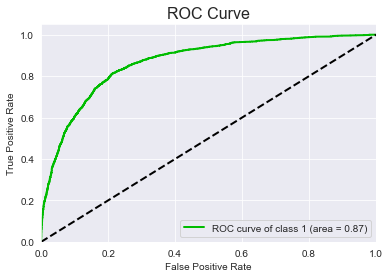

In [45]:
# ROC curve for the best model
pred_prob = lr_classifier.predict_proba(X_valid_cvec)
skplt.metrics.plot_roc(
    y_valid_cvec,
    pred_prob,
    plot_micro=False,
    plot_macro=False,
    title="ROC Curve",
    classes_to_plot=[1],
    title_fontsize=16,
)
plt.savefig("plot4.png")
plt.show()

In [46]:
pred = get_results(
    lr_classifier,
    X_train_cvec,
    y_train_cvec,
    X_valid_cvec,
    y_valid_cvec,
    return_pred=True,
)

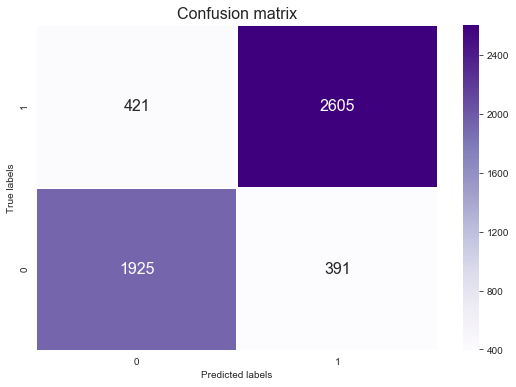

In [47]:
# Confusion matrix curve for the best model
f, ax = plt.subplots(figsize=(9, 6))
labels = [1, 0]
sns.heatmap(
    confusion_matrix(pred, y_valid_cvec, labels),
    annot=True,
    fmt="d",
    linewidths=0.9,
    ax=ax,
    cmap="Purples",
    annot_kws={"fontsize": 16},
)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion matrix", fontsize=16)
ax.set_ylim([0, 2])
plt.savefig("plot5.png")